**Data info**

It's Sunday morning, it's quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather "internationally". You pick it up slowly and hear something really bizarre - "Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.". What could possibly be so urgent for someone from Switzerland to call you at this hour? "Did you authorize a transaction for $3,358.65 for 100 copies of Diablo 3?" Immediately, you start thinking of ways to explain why you did that to your loved one. "No, I didn't !?". Michele's answer is quick and to the point - "Thank you, we're on it". Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week - Michele didn't call then.



Annual global fraud losses reached $21.8 billion in 2015, according to Nilson Report.

Probably you feel very lucky if you are a fraud. About every 12 cents per $100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.

In this part of the series, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [3]:
df = pd.read_csv("/content/creditcard.csv")
df.shape

(146652, 31)

In [4]:
df.isnull().values.any()

True

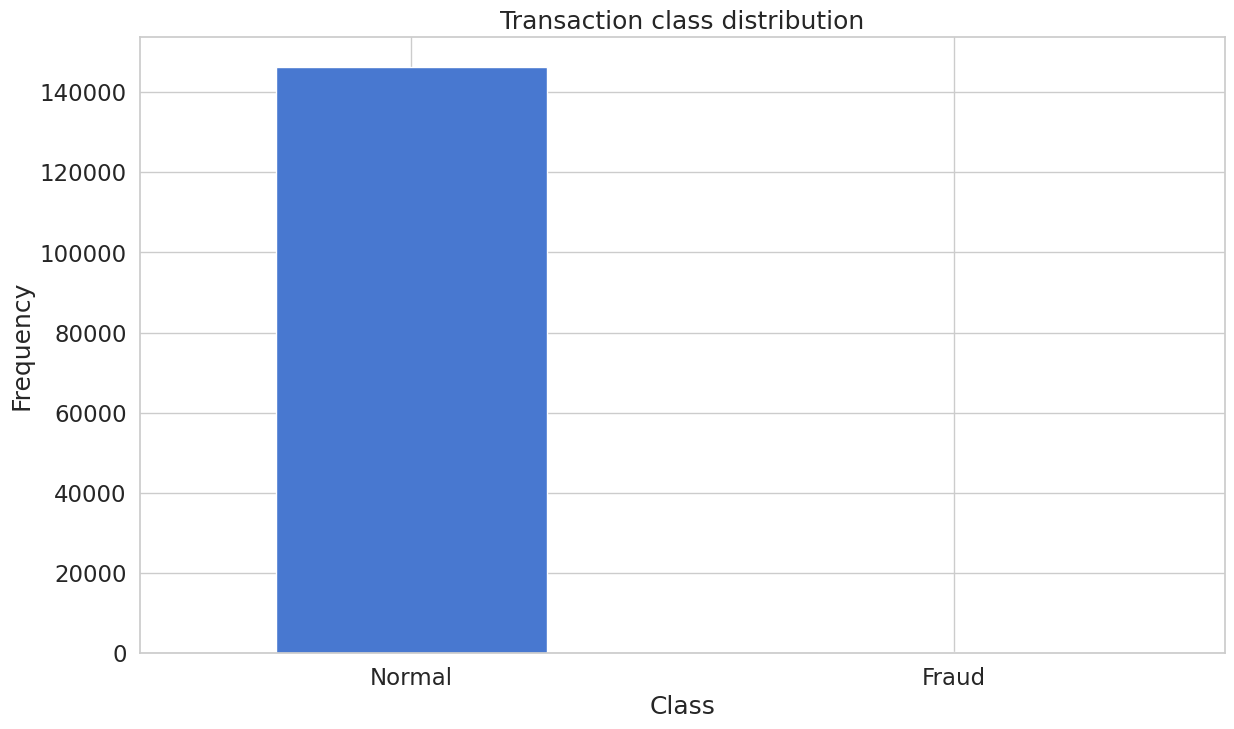

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

frauds.shape


(282, 31)

In [10]:

normal.shape

(146369, 31)

In [11]:
frauds.Amount.describe()

count     282.000000
mean      119.469433
std       242.629930
min         0.000000
25%         1.000000
50%        10.685000
75%       105.695000
max      1809.680000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    146369.000000
mean         89.883061
std         244.863711
min           0.000000
25%           5.920000
50%          23.000000
75%          79.950000
max       19656.530000
Name: Amount, dtype: float64

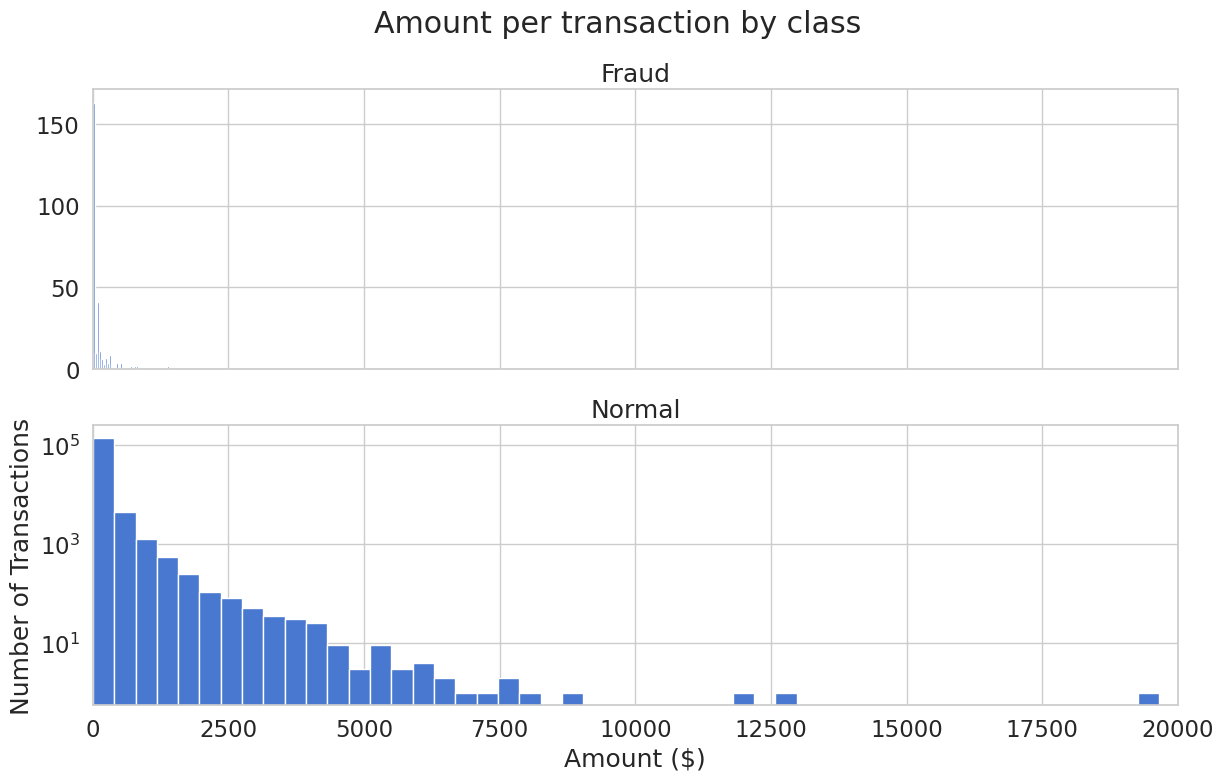

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

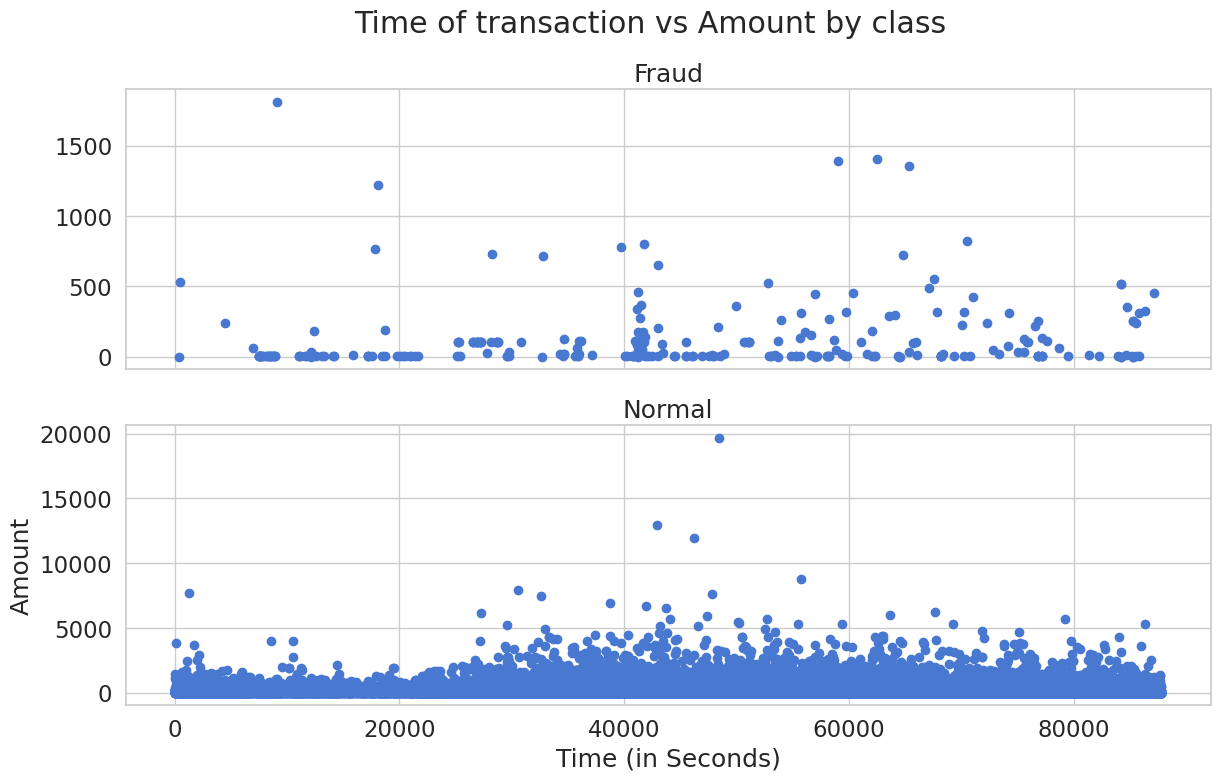

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [16]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [17]:
X_train.shape

(117096, 29)

In [18]:
#building the model
input_dim = X_train.shape[1]
encoding_dim = 14

In [19]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [23]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
3660/3660 [==============================] - 16s 4ms/step - loss: 0.6472 - accuracy: 0.7151 - val_loss: 0.6962 - val_accuracy: 0.7112
Epoch 2/100
3660/3660 [==============================] - 9s 2ms/step - loss: 0.6466 - accuracy: 0.7175 - val_loss: 0.6956 - val_accuracy: 0.7189
Epoch 3/100
3660/3660 [==============================] - 8s 2ms/step - loss: 0.6462 - accuracy: 0.7204 - val_loss: 0.6947 - val_accuracy: 0.7147
Epoch 4/100
3660/3660 [==============================] - 9s 2ms/step - loss: 0.6455 - accuracy: 0.7216 - val_loss: 0.6933 - val_accuracy: 0.7309
Epoch 5/100
3660/3660 [==============================] - 10s 3ms/step - loss: 0.6451 - accuracy: 0.7236 - val_loss: 0.6932 - val_accuracy: 0.7286
Epoch 6/100
3660/3660 [==============================] - 8s 2ms/step - loss: 0.6444 - accuracy: 0.7250 - val_loss: 0.6961 - val_accuracy: 0.7188
Epoch 7/100
3660/3660 [==============================] - 9s 2ms/step - loss: 0.6439 - accuracy: 0.7253 - val_loss: 0.6920 - val_

In [21]:
autoencoder = load_model('model.h5')

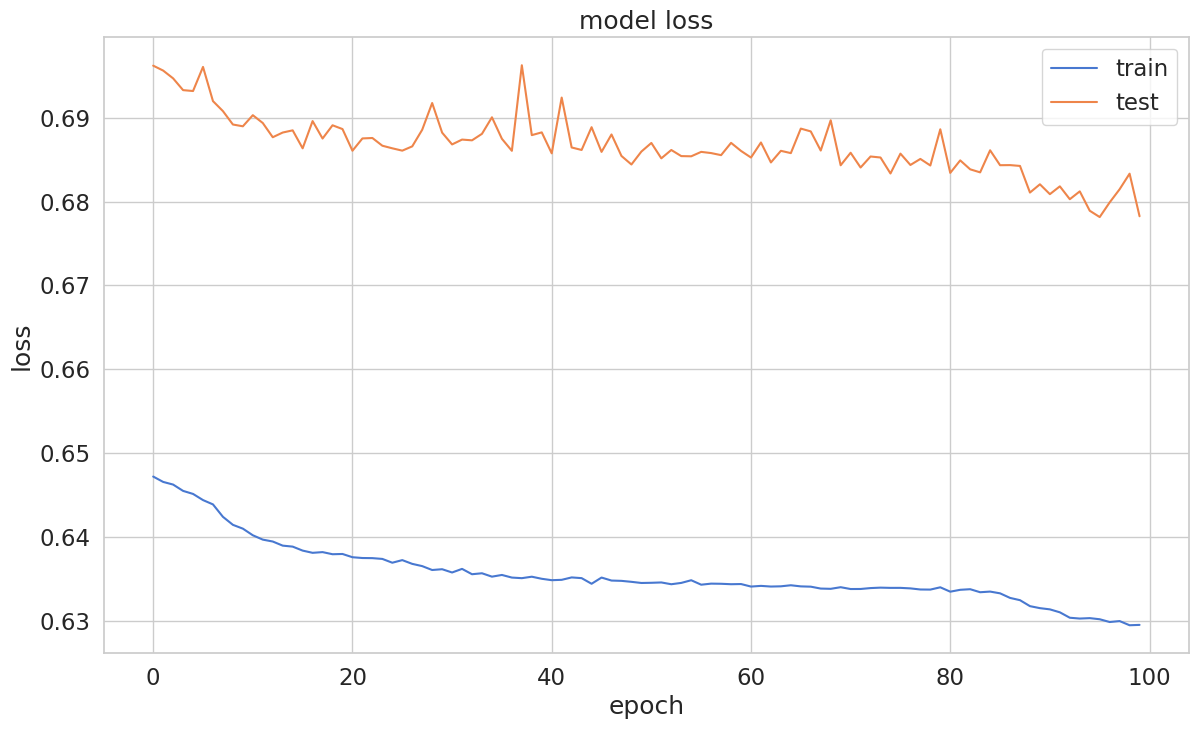

In [24]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [25]:
predictions = autoencoder.predict(X_test)

917/917 [==============================] - 3s 2ms/step


In [26]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [27]:
error_df.describe()

,reconstruction_error,true_class
count,29331.000000,29331.000000
mean,0.677399,0.001977
std,2.858934,0.044425
min,0.034229,0.000000
25%,0.182261,0.000000
50%,0.324204,0.000000
75%,0.557217,0.000000
max,109.366081,1.000000


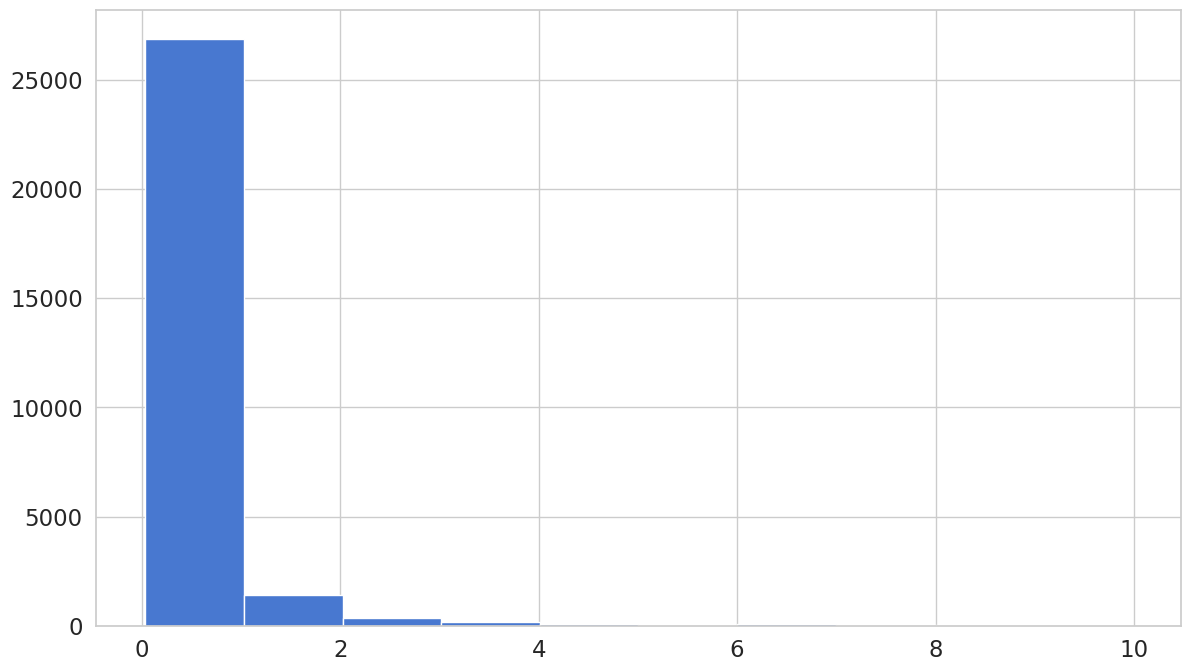

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [29]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

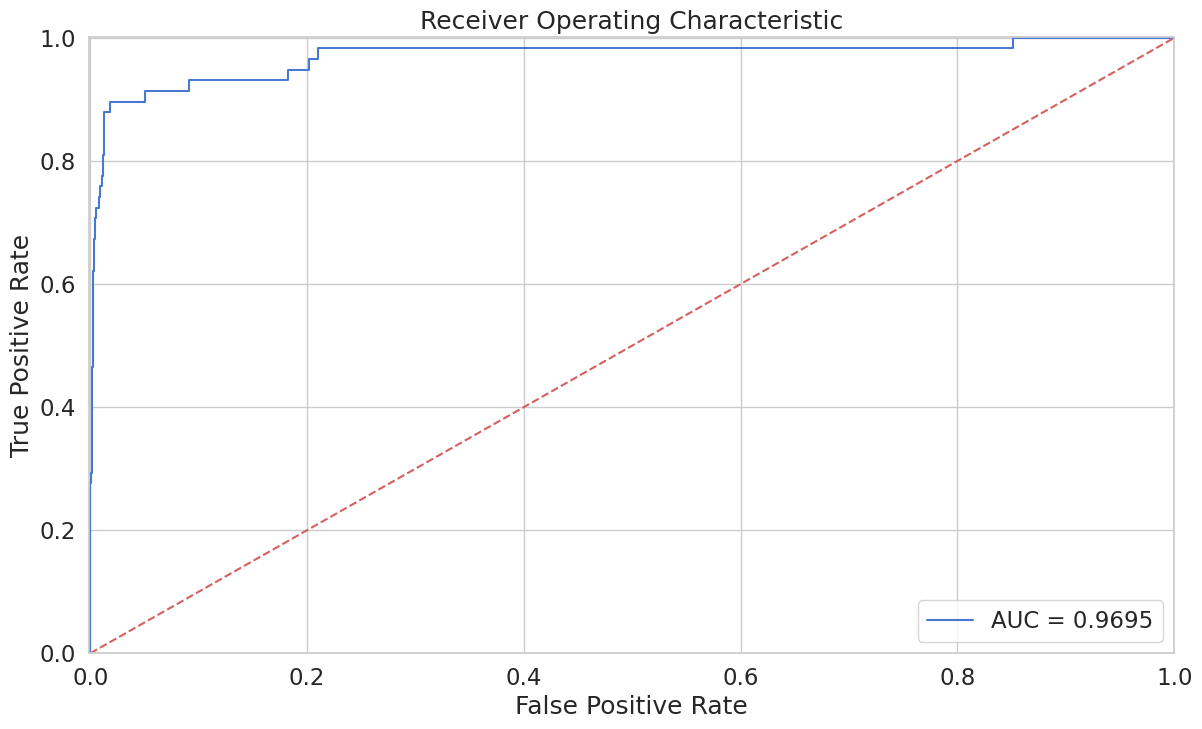

In [30]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

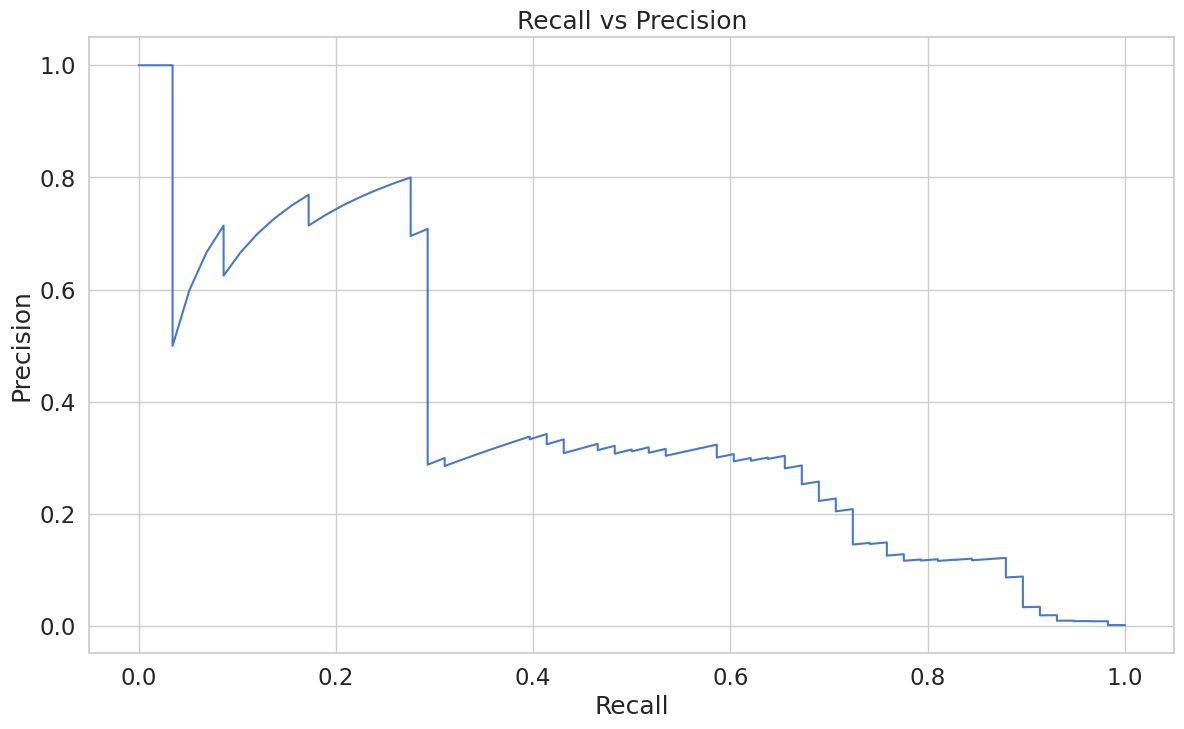

In [31]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

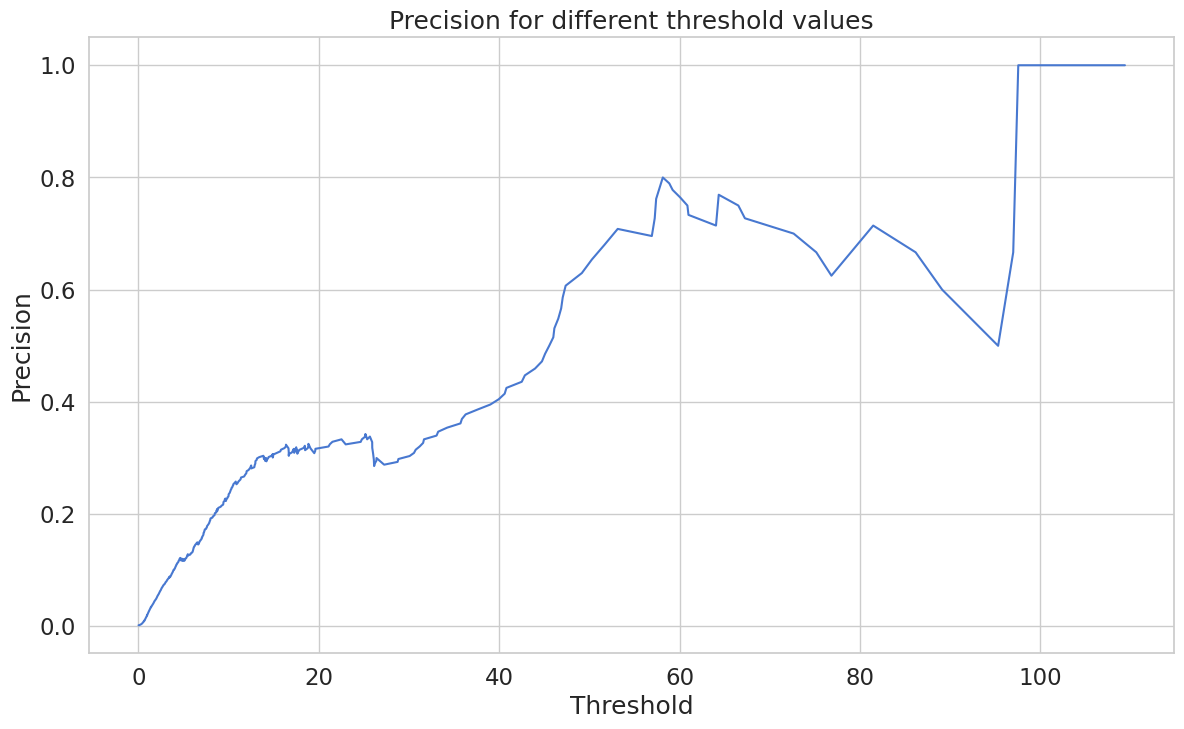

In [32]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

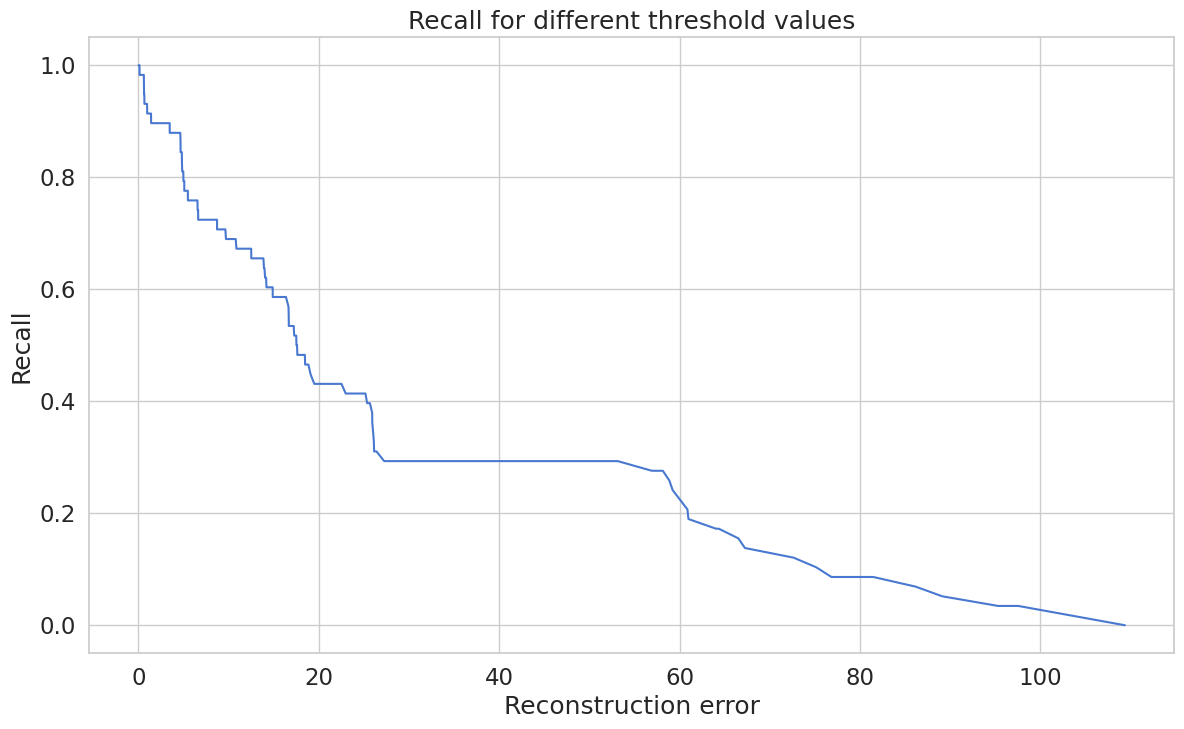

In [33]:
  plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [34]:
threshold = 2.9

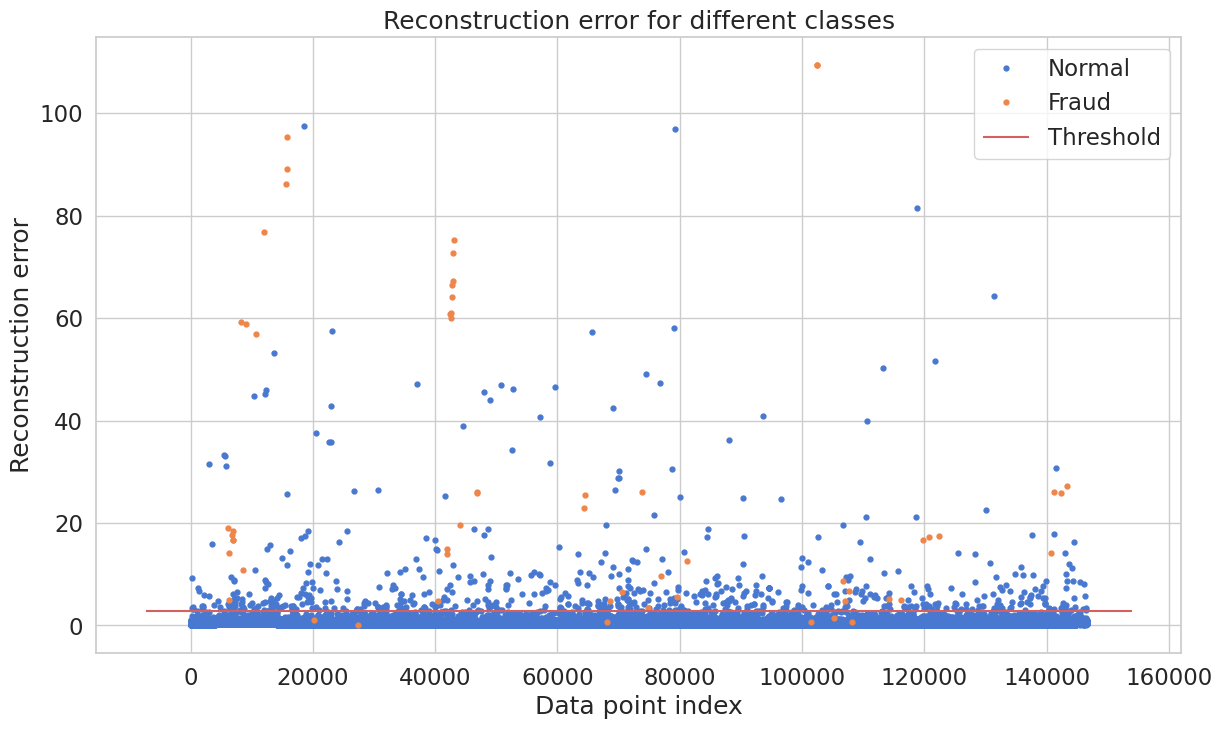

In [35]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

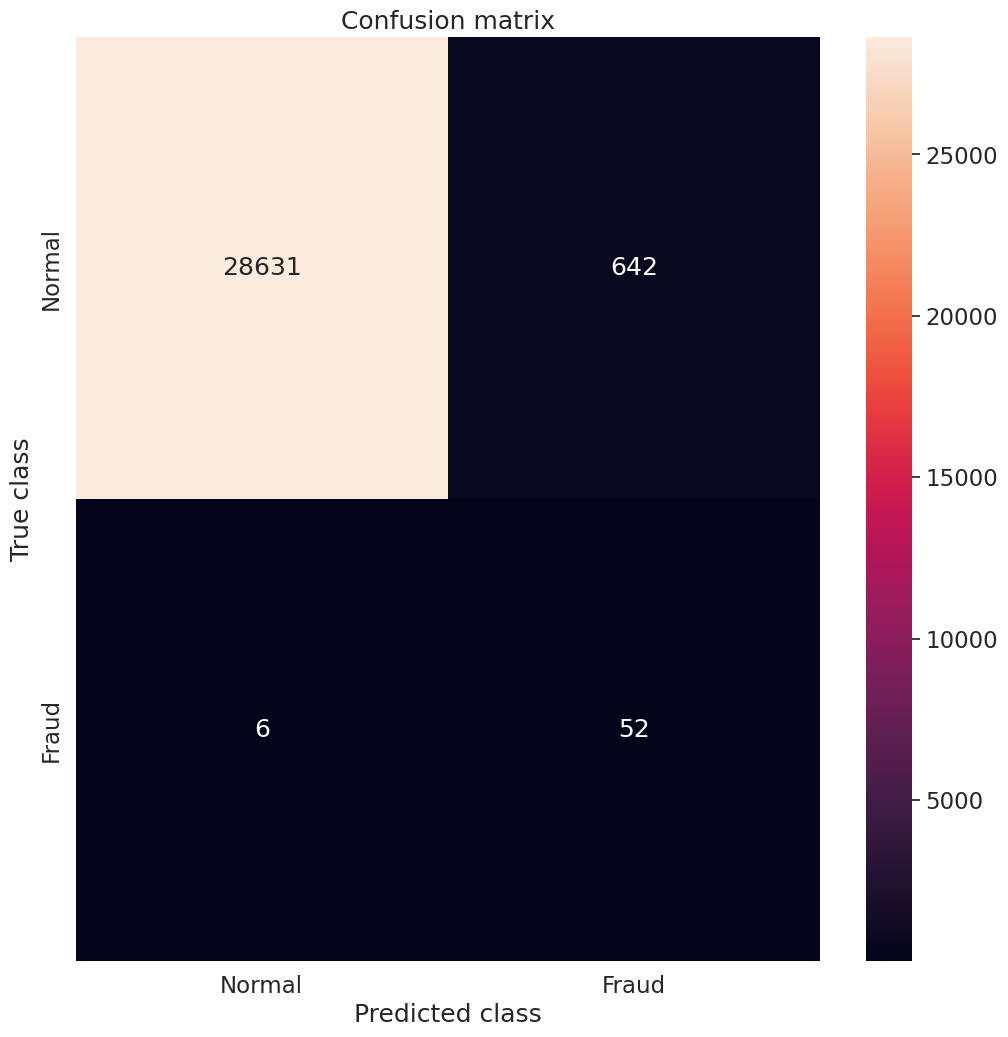

In [36]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()